In [164]:
import numpy as np
import os, sys, subprocess
import pandas as pd
import matplotlib.pyplot as plt


# We introduce functions in-line here, but they can be saved and imported as follows
# sys.path.insert(0, '../')  # Adds the project root to the PYTHONPATH
# from rsfc_tools import helpers

# Load in data

In [7]:
# First subject
sub_XC = np.genfromtxt('../data/rsfMRI_timeseries/sub-XC_parcellated_timeseries.txt')

# Second subject
sub_XA = np.genfromtxt('../data/rsfMRI_timeseries/sub-XA_parcellated_timeseries.txt')

In [8]:
# Looking at the shape of the data we just loaded in, we see it's 333 rows and 6000 columns

# The 333 rows represent 333 functionally homogonous regions of cortex known as "parcels"
# The 6000 columns represent 6000 frames of BOLD activity at each parcel

print(sub_XC.shape)
print(sub_XA.shape)

(333, 6000)
(333, 6000)


In [9]:
# OK that works for two subjects, what if you wanted to load in many?

# You'll want a list of all subjects in the analysis. This could be saved in a text file.
sub_list = np.genfromtxt('../data/sub_list.txt', str)
print(sub_list)

#Then you'll loop through the list and read in each subjects data.
data_dir = '../data/rsfMRI_timeseries'
rsfmri_data = np.zeros((len(sub_list),333,6000))

for i,sub in enumerate(sub_list):
    path_to_read = os.path.join(data_dir, f'sub-{sub}_parcellated_timeseries.txt')
    subject_data = np.genfromtxt(path_to_read)
    rsfmri_data[i] = subject_data

['XC' 'XA']


In [10]:
# Data structure holding all participants data in the order presented in sub_list
print(rsfmri_data.shape)

(2, 333, 6000)


# Data wrangling and exploration

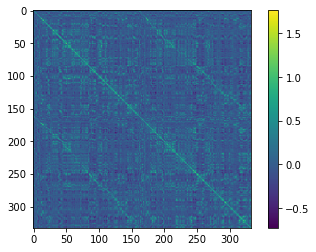

In [11]:
# Functional connectivity is the correlation structure between the timeseries at different brain regions

# np.corrcoef returns a correlation matrix that gives the correlation between all pairs of parcels (rows)
sub_XC_rsFC = np.corrcoef(sub_XC)

# We apply a Fisher Z-Transformation
np.fill_diagonal(sub_XC_rsFC, 0)
sub_XC_rsFC = np.arctanh(sub_XC_rsFC)
np.fill_diagonal(sub_XC_rsFC, 1)

# plt.imshow can be used to quickly view the correlation matrix we just created
plt.imshow(sub_XC_rsFC)
plt.colorbar()
plt.show()

In [12]:
# OK that works for one subject. What if we wanted to do create the correlation matrix for everyone?

# First, create a function that takes in a the rsFMRI timeseries data, and outputs the z-transformed connectivty
def create_corrmat(arr):
    """
    Generate a Fisher-transformed correlation matrix from a time series array.
    
    Parameters
    ----------
    arr : array_like
        2D array with shape (n_parcels, m_frames) where n_parcels is the number of parcels
        (variables) and m_frames is the number of frames (time points).
    Returns
    -------
    corrmat : ndarray
        The Fisher-transformed correlation matrix with the shape as `n x n`, where each
        element corrmat [i, j] represents the Fisher-transformed correlation coefficient
        between parcel i and parcel j. 
    """
    corrmat = np.corrcoef(arr)
    np.fill_diagonal(corrmat, 0)
    corrmat = np.arctanh(corrmat)
    np.fill_diagonal(corrmat, 1)
    return corrmat

# Then, apply that function to every participant. 
rsfc_data = np.zeros((len(sub_list),333,333))

# Loop though the participants in the rsFMRI data struture, create and store the correlation matricies
for i,sub in enumerate(rsfmri_data):
    rsfc_data[i] = create_corrmat(sub)

# Now we have connectivity data for each participant
print(rsfc_data.shape)

(2, 333, 333)


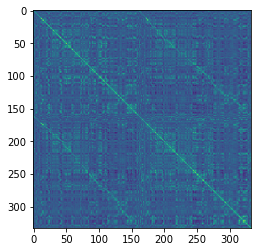

In [13]:
# One thing we may want to do is sisualize the mean connectivity of the group. plt.imshow is an easy way to do this

plt.imshow(rsfc_data.mean(0))
plt.show()

In [14]:
# We can see that the correlation matrix is currently unordered. It doesn't display the block-diagonal structure
# Representing groupings of highly correlated brain regions ('functional networks')

# One way to visualize functional networks is to re-order the parcels based off the community structure
# in the graph created by the above (or similar, group averaged) correlation matrixs

# First we load in the community structure from a group averaeg graph, created off this parcel set 
# Generation and Evaluation of a Cortical Area Parcellation from Resting-State Correlations (Gordon et al., 2016)

parcel_labels = pd.read_excel('../data/Parcels.xlsx')
parcel_labels

/Users/matt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


ParcelID Hem  Surface area (mm2)    Centroid (MNI)    Community
0           1   L           1411.6436  -11.2 -52.4 36.5      Default
1           2   L            377.2543    -18.8 -48.7 65       SMhand
2           3   L            437.1466   -51.8 -7.8 38.5      SMmouth
3           4   L            368.6362     -11.7 26.7 57      Default
4           5   L            870.9255  -18.4 -85.5 21.6       Visual
..        ...  ..                 ...               ...          ...
328       329   R             15.9589    39.7 -22.5 2.6     Auditory
329       330   R            415.3981         55.8 2 -2     Auditory
330       331   R            101.3923    54.4 1.1 -12.9      Default
331       332   R            129.5680    57.1 -6.3 -7.7  VentralAttn
332       333   R             66.6635   46.6 -21.5 -8.5  VentralAttn

[333 rows x 5 columns]

In [33]:
# This gives us information on each of the 333 parcels. We are currently interested in the 'Community' column
# Specifically, we want to sort the parcels by their canonical community label.

# We the indicies which sort the parcels by community alphabetically
reorder_indicies = parcel_labels['Community'].argsort()
reordered_communities = parcel_labels['Community'].sort_values()


# We get the unique networks, in the order they were sorted.
# As well as the first occurence of a parcel in each network, which will be helpful later on.
unique_networks, first_occurrences = np.unique(parcel_labels['Community'][reorder_indicies],return_index=True)
sorted_unique_networks = unique_networks[np.argsort(first_occurrences)]
print(sorted_unique_networks)
print(first_occurrences)

['Auditory' 'CinguloOperc' 'CinguloParietal' 'Default' 'DorsalAttn'
 'FrontoParietal' 'None' 'RetrosplenialTemporal' 'SMhand' 'SMmouth'
 'Salience' 'VentralAttn' 'Visual']
[  0  24  64  69 110 142 166 213 221 259 267 271 294]


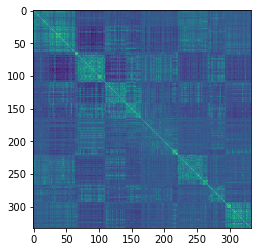

In [16]:
# Now we can re-visalize our group average connectivity, with parcels sorted by canonical functional network
plt.imshow(rsfc_data.mean(0)[reorder_indicies,:][:,reorder_indicies])
plt.show()

# We notice the block-diagonal structure appears, which compose the densely interconnected communities of parcels


# We can reorganize our rsfc_data for each participant, based on this new ordering, which will be helpful later on.
rsfc_data_ordered = np.copy(rsfc_data[:,reorder_indicies,:][:,:,reorder_indicies])

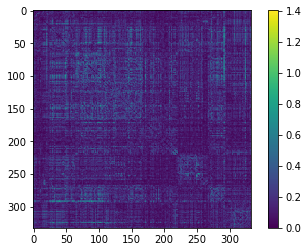

In [218]:
# Now we have our data in a more interpretable format suitable for further exploration and analysis.

# For example, we a simple demonstration we can look at the difference in connectivity between our two participants
difference_matrix = np.abs(rsfc_data_ordered[0,:,:]-rsfc_data_ordered[1,:,:])
plt.imshow(difference_matrix)
plt.colorbar()
plt.show()

# # Applying a smoothing filter often makes visualizing differences in blocks of the network organization easier
# # (You would not want to use this filter during quantiatiive analyses, as it blurs across network borders)
# from scipy.ndimage import gaussian_filter
# plt.imshow(gaussian_filter(difference_matrix,1.5))
# plt.colorbar()
# plt.show()

0.26415154203542757


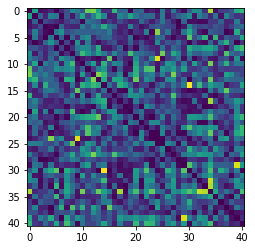

In [223]:
# Now to query regions of the correlation matrix, we need to get the rows/columns belonging to the block of interest
# For example if, we want to see differences between the participants within the default mode network

default_inds = np.where(reordered_communities=='Default')[0]
difference_matrix_default = difference_matrix[default_inds,:][:,default_inds]

# Visualize just the DMN-DMN block
plt.imshow(difference_matrix_default)

#Print the mean absolute difference between the two 
print(np.mean(difference_matrix_default))

In [224]:
# What if we want to look at differences for each block, both within and between different networks
from itertools import combinations_with_replacement

# Define the list of combinations to loop through. The first 5 in the list are printed out for example
combo_list = list(combinations_with_replacement(unique_networks,2))
print(combo_list[:5])


# Loop through the list of combinations of networks and keep track of the mean absolute differences for each block
mean_differences = []
for combo in combo_list:
    net1,net2 = combo
    net1_inds = np.where(reordered_communities==net1)[0]
    net2_inds = np.where(reordered_communities==net2)[0]
    difference_matrix_subset = difference_matrix[net1_inds,:][:,net2_inds]
    mean_differences.append(np.mean(difference_matrix_subset))

[('Auditory', 'Auditory'), ('Auditory', 'CinguloOperc'), ('Auditory', 'CinguloParietal'), ('Auditory', 'Default'), ('Auditory', 'DorsalAttn')]


In [225]:
# Print out the top 10 differences

sorted_abs_difference_indices = np.argsort(np.abs(mean_differences))[::-1]
for i in range(10):
    print(np.array(combo_list)[sorted_abs_difference_indices[i]])
    print(np.array(mean_differences)[sorted_abs_difference_indices][i])

# # To print out all differences
# for i, combo in enumerate(combo_list):
#     print(f'{combo} has mean difference between participant of {mean_differences[i]}')

['CinguloParietal' 'CinguloParietal']
0.38309069132250256
['RetrosplenialTemporal' 'RetrosplenialTemporal']
0.32038925780382543
['CinguloParietal' 'Default']
0.28730091485164977
['Default' 'VentralAttn']
0.27426965779136675
['Default' 'Default']
0.26415154203542757
['Default' 'FrontoParietal']
0.24382031800936707
['CinguloOperc' 'VentralAttn']
0.23537287185915837
['VentralAttn' 'VentralAttn']
0.23411804861905114
['CinguloOperc' 'FrontoParietal']
0.2319872042949991
['FrontoParietal' 'FrontoParietal']
0.23157752669189058


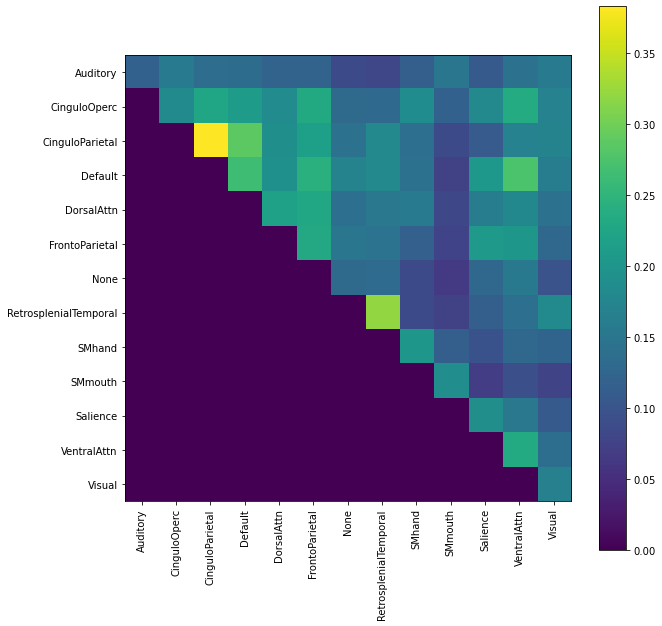

In [228]:
# Visualize the mean absolute differences between the participants, for each block
array = np.zeros((13, 13))
tri_upper_indices = np.triu_indices_from(array)

array[tri_upper_indices] = mean_differences
plt.figure(figsize=(10,10))
plt.imshow((array))
plt.xticks(ticks = range(13), labels=unique_networks, rotation = 90)
plt.yticks(ticks = range(13), labels=unique_networks)
plt.colorbar()
plt.show()

So far, we loaded in parcellated timeseries data for two participants, then created the z-transformed connectivity for each participant. Then, after reording the parcels, we were able to calcuate the absolute difference in connectivity between the participants. This was then grouped by the canonical network definition of the parcel which we imported.

Taking a step back, we can view the gordon parcellation (the 333 parcels we have been working with), with the associatied network labels colored on to the parcels. 

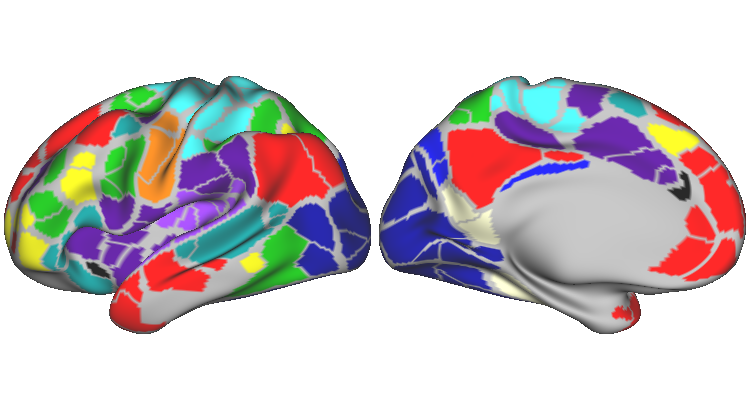


The largest differences between these participants  appear are in blocks consist of CinguloParietal, Retrosplenial, and default networks. These are the beige, neon blue, and red networks respectively, colored in on the gordon parcellation.

Note: To view these images by yourself, you would need to install connectome workbench https://www.humanconnectome.org/software/connectome-workbench, open up a cortical surface (e.g.; Conte69.R.inflated.32k_fs_LR.surf.gii), and then open up the parcel communty file (e.g.; Parcel_Communities.ptseries.nii). For your convenience, I include copies of these files inside ./data/misc


In [243]:
# What if we want to visualize the parcels which have large differences in connectivity between the participants?

# Create the difference matrix using the original connectivity matrix, ordered by parcel number which will be important later on
difference_matrix_unordered = np.abs(rsfc_data[0,:,:]-rsfc_data[1,:,:])

#calculate the mean difference for each parcel 
mean_parcel_difference = np.mean(difference_matrix_unordered,0)
print(mean_parcel_difference.shape)

# Now we want to overlay these numbers on top of the gordon parcellation
# This step requires having connectome workbench installed, providing your path_to_wb, which will be used to write
# the file to visualize

# Here is a function I created to make this process easier
# You may need to edit the path_to_wb variable with your own local path to the workbench installation
def save_nii(array, output_name, output_dir_path, wb_required_template_path, purge = True):
    
    path_to_wb = '/Applications/workbench/bin_macosx64/wb_command'

    
    '''
    Save a numpy array as a .nii file, utilizing workbench as an intermediary.
    Arguments:
        array: the numpy array to save
        output_name: the name to use for the output file
        output_dir_path: the directory path to save the output file in
        wb_required_template_path: a dtseries of the same dimension used as a template to write over
        purge: if True, delete the intermediate text file after creating the .nii file
    '''
    if not os.path.isdir(output_dir_path):
        raise Exception(f"The output folder {output_dir_path} does not exist")
    template_base = os.path.basename(wb_required_template_path)
    end = template_base.find('.')
    file_end = template_base[end:]
    out_path = os.path.join(output_dir_path, output_name)
    outnamecifti = out_path+file_end
    if os.path.isfile(outnamecifti):
        print('-WARNING: Overwriting')
    np.savetxt(out_path, array)
    wb_comm = ' '.join([path_to_wb, '-cifti-convert -from-text', out_path, wb_required_template_path, outnamecifti])
    subprocess.call(wb_comm, shell=True)
    if purge:
        os.remove(out_path)
        

        
# Note the arguments in this function call. First you provide the 333 values, ordered by gordon parcel # to write       
# Then you provide the desired output name, and output location
# Finally you must provide a .nii template, which workbench requires inorder to write new values ontop of.
# A copy of this template, Gordon333_TEMPLATE.pscalar.nii, is provided for your convenience in /data/misc
save_nii(mean_parcel_difference, 'mean_parcel_difference', '../results/', '../data/misc/Gordon333_TEMPLATE.pscalar.nii')

(333,)
-WARNING: Overwriting


Opening up the file (which is written as an example into ./results), lets us visualize the cortical regions whose whole brain connectivity differs the most between the two participants

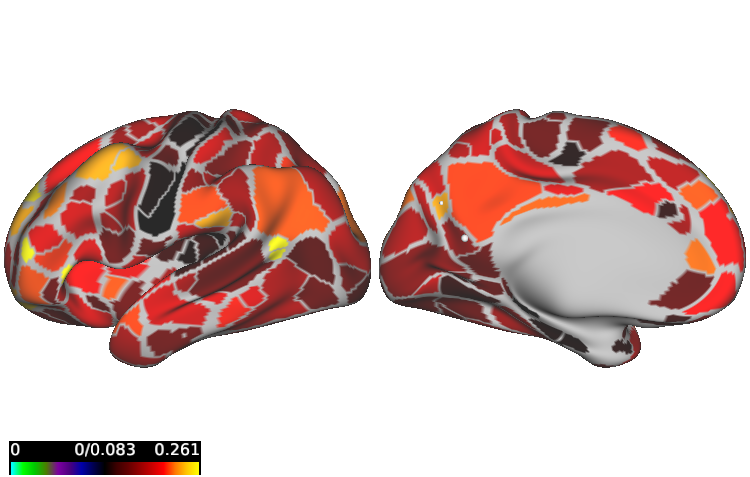

In [241]:
# a = []
# for i in range(333):
#     a.append(np.corrcoef(rsfc_data[0,i,:],rsfc_data[1,i,:])[0,1])